<a href="https://colab.research.google.com/github/AdamKhanBM/AdamKhanBM/blob/main/BioLab__DAPI_ANALIZER_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path
path = '/content/drive/My Drive/Analysis/DAPI/250218_DAPI_SW_MAG0032/20X'

# Change the current working directory to `path`
os.chdir(path)

# Function to print directories recursively
def list_directories(path, level=0):
    for item in os.listdir(path):
        if os.path.isdir(item):
            print('  ' * level + f"- {item}/")
            list_directories(item, level + 1)
        else:
            print('  ' * level + f"- {item}")

# List directories starting from the current working directory
list_directories('.')

Mounted at /content/drive
- C_1.czi
- C_2.czi
- C_3.czi
- LD_1.czi
- LD_2.czi
- LD_3.czi
- HD_1.czi
- HD_2.czi
- HD_3.czi
- C_1.tiff
- C_2.tiff
- C_3.tiff
- LD_1.tiff
- LD_2.tiff
- LD_3.tiff
- HD_1.tiff
- HD_2.tiff
- HD_3.tiff


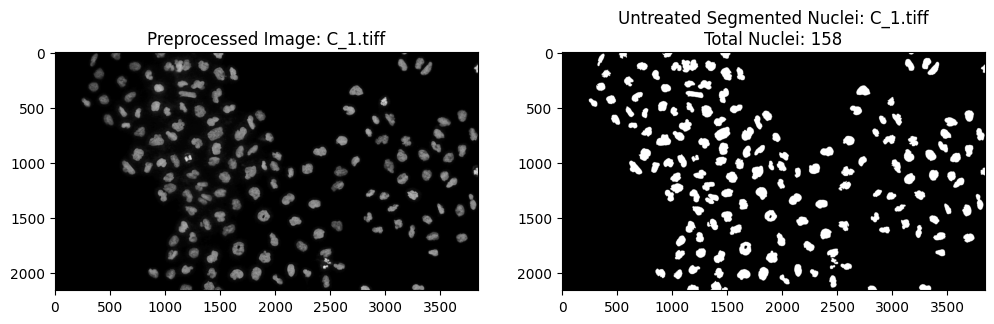

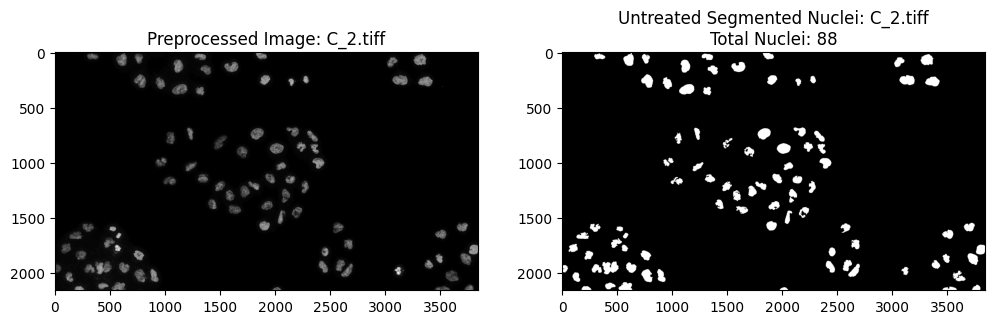

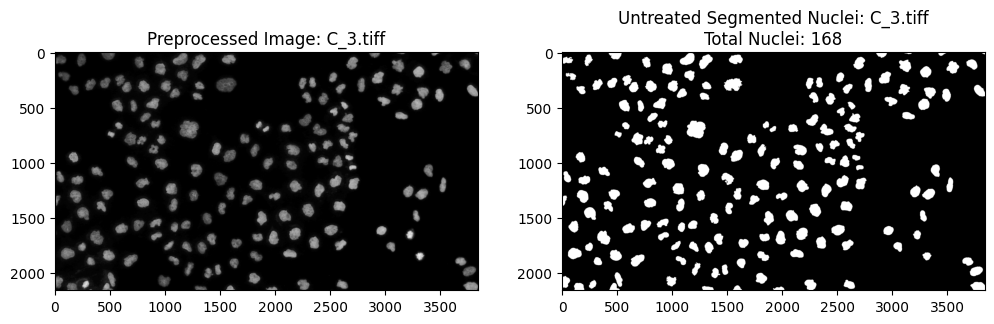

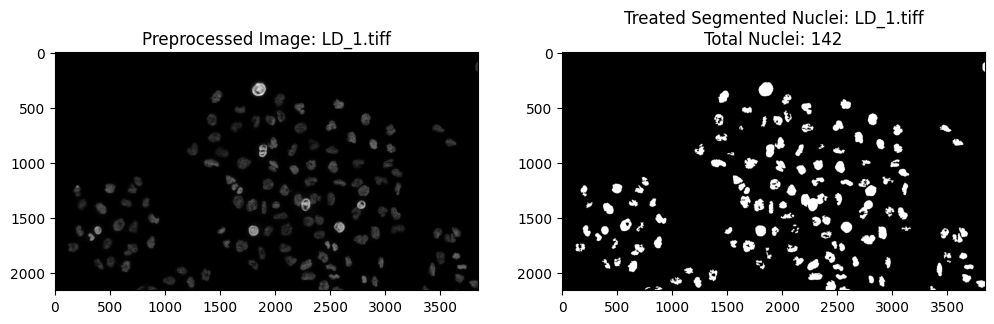

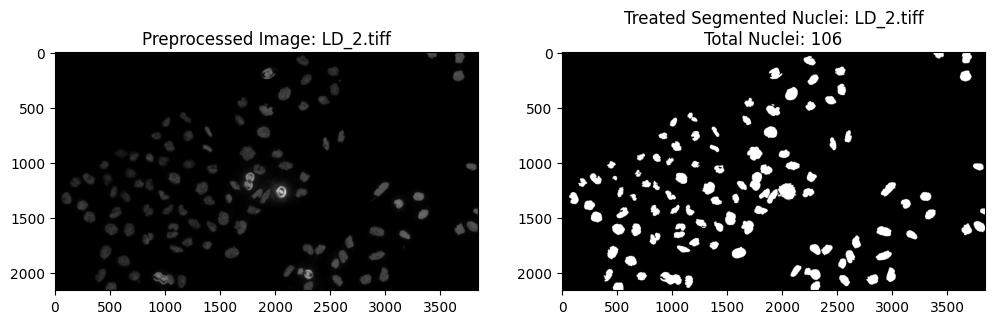

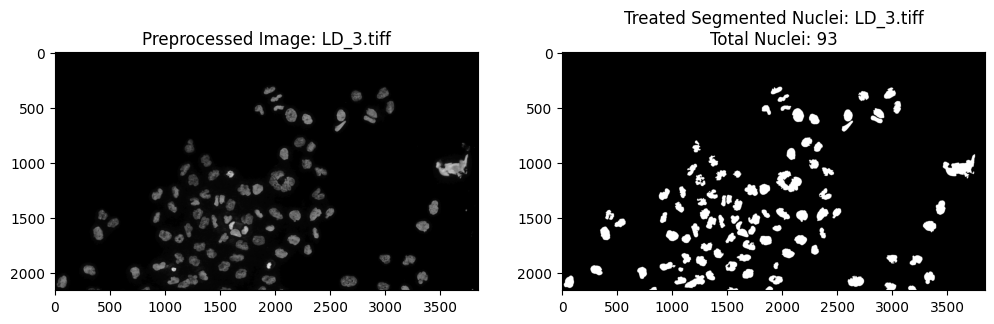

Nuclei counts for untreated samples: 414
Nuclei counts for treated samples: 341


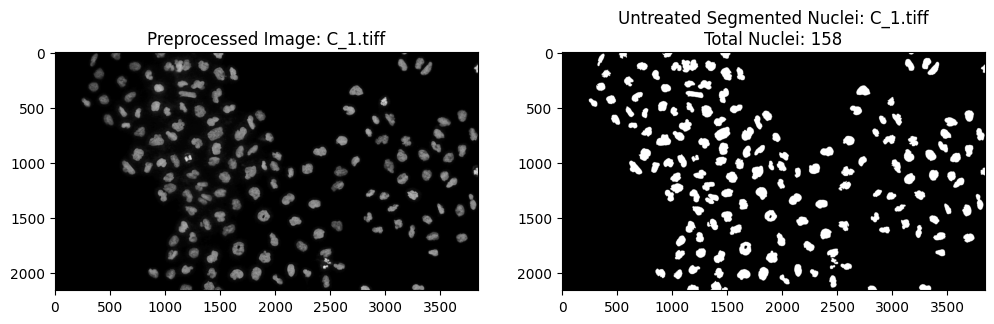

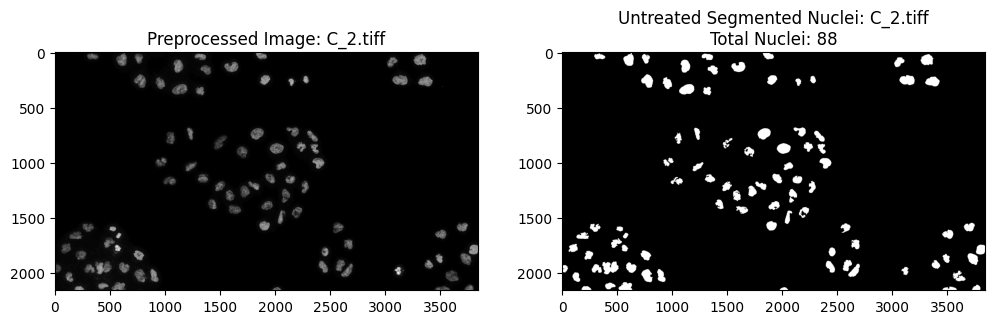

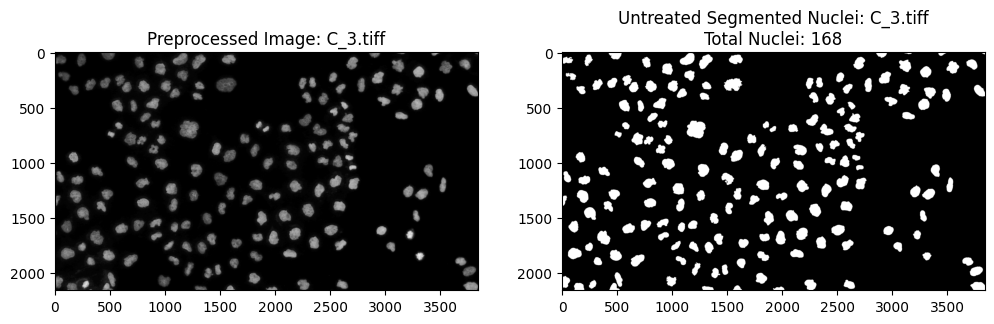

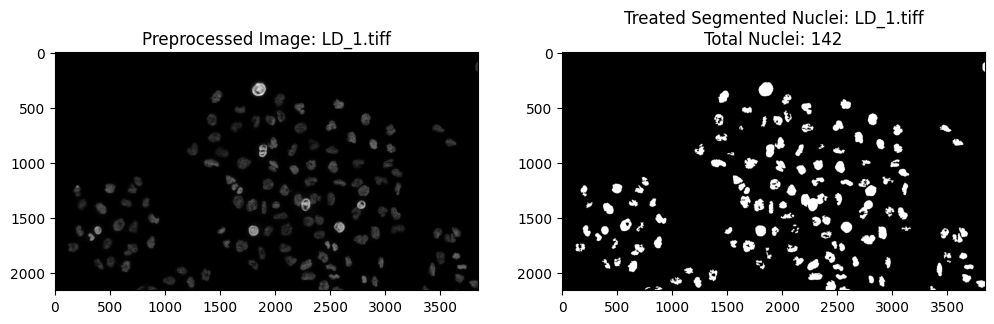

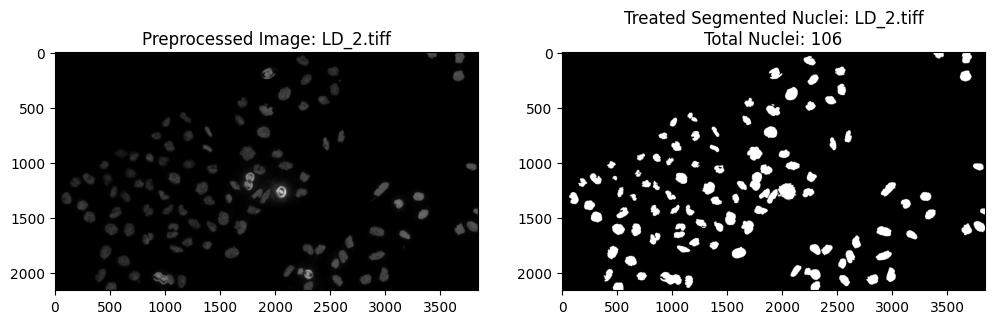

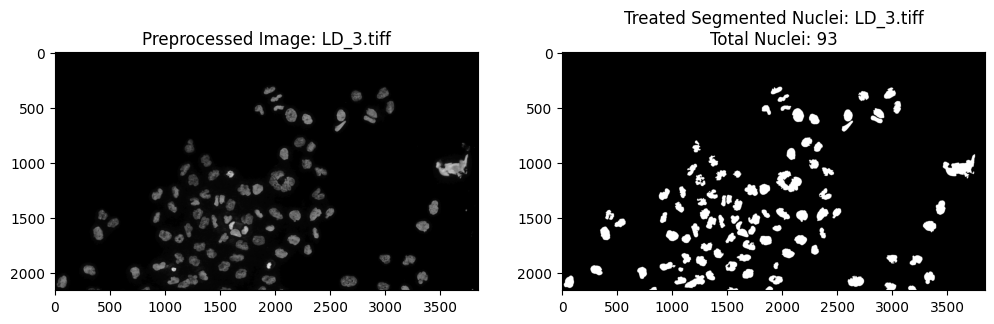

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd
import cv2
from skimage import filters, measure, segmentation, feature
from scipy import ndimage as ndi
from scipy.ndimage import morphology

import cv2
import numpy as np
import pandas as pd
from skimage import filters, measure, morphology
from skimage.filters import gaussian
from skimage.morphology import disk, remove_small_objects, remove_small_holes
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# Image paths for each group
untreated_image_paths = [
    'C_1.tiff', 'C_2.tiff', 'C_3.tiff'
    # Add more untreated images as needed
]

treated_image_paths = [
     'LD_1.tiff', 'LD_2.tiff', 'LD_3.tiff'
    # Add more treated images as needed
]
def preprocess_image(image_path):
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply Gaussian blur
    image_blurred = gaussian(image, sigma=1)
    return image_blurred

def subtract_background(image):
    # Estimate background using a median filter
    background = median(image, disk(30))
    subtracted_image = image - background
    return subtracted_image

def segment_nuclei(image):
    # Threshold image using Otsu's method
    thresh = filters.threshold_otsu(image)
    binary_mask = image > thresh
    # Perform morphological operations
    cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))
    cleaned_mask = remove_small_objects(cleaned_mask, min_size=250)
    cleaned_mask = remove_small_holes(cleaned_mask, area_threshold=250)
    return cleaned_mask
def count_nuclei(mask):
    labeled_mask, num_labels = measure.label(mask, return_num=True)
    return num_labels


def extract_features(binary_mask, original_image):
    labeled_mask = measure.label(binary_mask)
    properties = measure.regionprops(labeled_mask, intensity_image=original_image)
    features = [{'Area': prop.area,
                 'Total Intensity': np.sum(prop.intensity_image),
                 'Intensity/Area Ratio': np.sum(prop.intensity_image) / prop.area}
                for prop in properties]
    return features

def process_images(image_paths, group_label):
    all_features = []
    for image_path in image_paths:
        raw_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        preprocessed_image = preprocess_image(image_path)
        background_subtracted_image = subtract_background(preprocessed_image)
        nuclei_mask = segment_nuclei(background_subtracted_image)
        features = extract_features(nuclei_mask, background_subtracted_image)
        for feature in features:
            feature['Group'] = group_label
            all_features.append(feature)
    return all_features

# Dictionaries to store nuclei counts
nuclei_counts = {
    'Untreated': 0,
    'Treated': 0
}
# Process images and count nuclei
for group, image_paths in [('Untreated', untreated_image_paths), ('Treated', treated_image_paths)]:
    for image_path in image_paths:
        preprocessed_image = preprocess_image(image_path)
        nuclei_mask = segment_nuclei(preprocessed_image)
        num_nuclei = count_nuclei(nuclei_mask)
        nuclei_counts[group] += num_nuclei  # Accumulate counts

        # Display the results
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(preprocessed_image, cmap='gray')
        ax[0].set_title(f'Preprocessed Image: {image_path}')
        ax[1].imshow(nuclei_mask, cmap='gray')
        ax[1].set_title(f'{group} Segmented Nuclei: {image_path}\nTotal Nuclei: {num_nuclei}')
        plt.show()

# Now you can use nuclei_counts['Untreated'] and nuclei_counts['Treated'] for further analysis or plots
print("Nuclei counts for untreated samples:", nuclei_counts['Untreated'])
print("Nuclei counts for treated samples:", nuclei_counts['Treated'])
def display_sample_images(image_path):
    # Display original, preprocessed, and segmented images for verification
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_image = preprocess_image(image_path)
    background_subtracted_image = subtract_background(preprocessed_image)
    nuclei_mask = segment_nuclei(background_subtracted_image)

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(preprocessed_image, cmap='gray')
    axs[1].set_title('Preprocessed Image')
    axs[2].imshow(nuclei_mask, cmap='gray')
    axs[2].set_title('Segmented Nuclei Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()


def count_nuclei(mask):
    labeled_mask, num_labels = measure.label(mask, return_num=True)
    properties = measure.regionprops(labeled_mask)
    areas = [prop.area for prop in properties]
    return labeled_mask, num_labels, areas

# Usage of the functions as per your previous script.



# Process each group
for group, image_paths in [('Untreated', untreated_image_paths), ('Treated', treated_image_paths)]:
    for image_path in image_paths:
        preprocessed_image = preprocess_image(image_path)
        nuclei_mask = segment_nuclei(preprocessed_image)
        _, num_nuclei, areas = count_nuclei(nuclei_mask)  # Count nuclei and get areas

        # Display the results
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(preprocessed_image, cmap='gray')
        ax[0].set_title(f'Preprocessed Image: {image_path}')
        ax[1].imshow(nuclei_mask, cmap='gray')
        ax[1].set_title(f'{group} Segmented Nuclei: {image_path}\nTotal Nuclei: {num_nuclei}')
        plt.show()



In [19]:
import pandas as pd
from skimage import measure
import scipy.stats as stats
import pandas as pd
from skimage import measure
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_features(binary_mask, original_image):
    labeled_mask = measure.label(binary_mask)
    properties = measure.regionprops(labeled_mask, intensity_image=original_image)
    features = []
    for prop in properties:
        area = prop.area
        total_intensity = np.sum(prop.intensity_image)  # Correct calculation for total intensity
        intensity_area_ratio = total_intensity / area if area > 0 else 0  # Avoid division by zero
        features.append({
            'Area': area,
            'Total Intensity': total_intensity,
            'Relative Intensity': intensity_area_ratio,
        })
    return features
def process_images(image_paths, group_label):
    # Process each image and store features with group labels
    all_features = []
    for image_path in image_paths:
        preprocessed_image = preprocess_image(image_path)
        nuclei_mask = segment_nuclei(preprocessed_image)
        features = extract_features(nuclei_mask, preprocessed_image)
        for feature in features:
            feature['Group'] = group_label
            all_features.append(feature)
    return all_features


# Process the images and extract features
untreated_features = process_images(untreated_image_paths, 'Untreated')
treated_features = process_images(treated_image_paths, 'Treated')

# Combine extracted features into a single DataFrame
all_features = untreated_features + treated_features
features_df = pd.DataFrame(all_features)

# Display the entire DataFrame
print(features_df)
 #Save the DataFrame to a CSV file
output_file_path = 'features_df.csv'
features_df.to_csv(output_file_path, index=False)

       Area  Total Intensity  Relative Intensity      Group
0    3149.0       177.453172            0.056352  Untreated
1    3296.0       207.483209            0.062950  Untreated
2    4159.0       408.698210            0.098268  Untreated
3     931.0        83.788581            0.089998  Untreated
4    3714.0       221.216386            0.059563  Untreated
..      ...              ...                 ...        ...
750  5583.0       241.767206            0.043304    Treated
751  2412.0       173.754158            0.072037    Treated
752  1693.0        77.600913            0.045836    Treated
753  1325.0        59.753546            0.045097    Treated
754  1520.0        60.381020            0.039724    Treated

[755 rows x 4 columns]


In [20]:
def perform_statistical_tests(df):
    results = []
    p_values = {}
    print("Performing t-tests between Untreated and Treated groups for 'Area' and 'Total Intensity':\n")
    for feature in ['Area', 'Total Intensity', 'Relative Intensity']:
        untreated = df[df['Group'] == 'Untreated'][feature]
        treated = df[df['Group'] == 'Treated'][feature]
        t_stat, p_val = stats.ttest_ind(untreated, treated, equal_var=False)
        result_line = f"{feature} - T-statistic: {t_stat}, P-value: {p_val}"
        print(result_line)
        results.append({'Feature': feature, 'T-statistic': t_stat, 'P-value': p_val})
        p_values[feature] = p_val  # Store p-value for each feature
    return results, p_values  # Return p-values for annotations

# Get the results and p-values
stat_results, p_values = perform_statistical_tests(features_df)

Performing t-tests between Untreated and Treated groups for 'Area' and 'Total Intensity':

Area - T-statistic: 2.559136982985166, P-value: 0.010744642953279085
Total Intensity - T-statistic: 8.93224844896655, P-value: 4.42716214700503e-18
Relative Intensity - T-statistic: 19.51324498596193, P-value: 7.822854028911226e-69


<ipython-input-21-846d113aea1a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y=feature, data=df, palette="pastel")


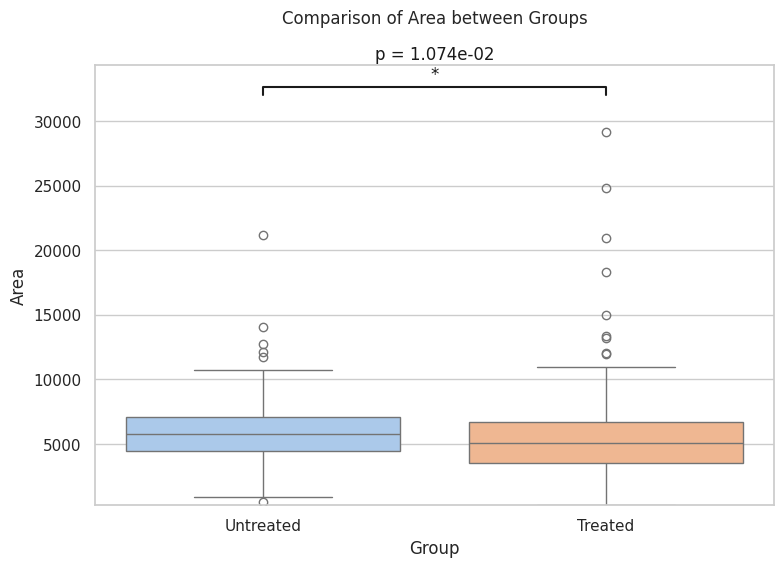

<ipython-input-21-846d113aea1a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y=feature, data=df, palette="pastel")


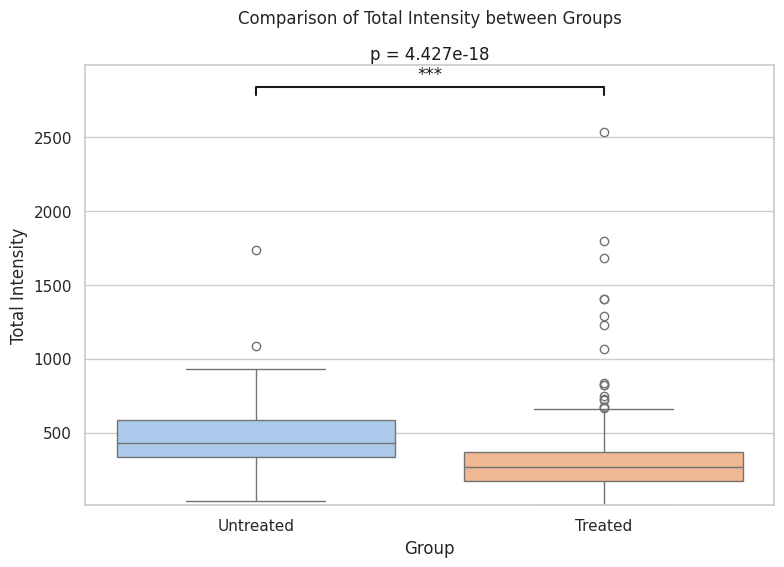

<ipython-input-21-846d113aea1a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y=feature, data=df, palette="pastel")


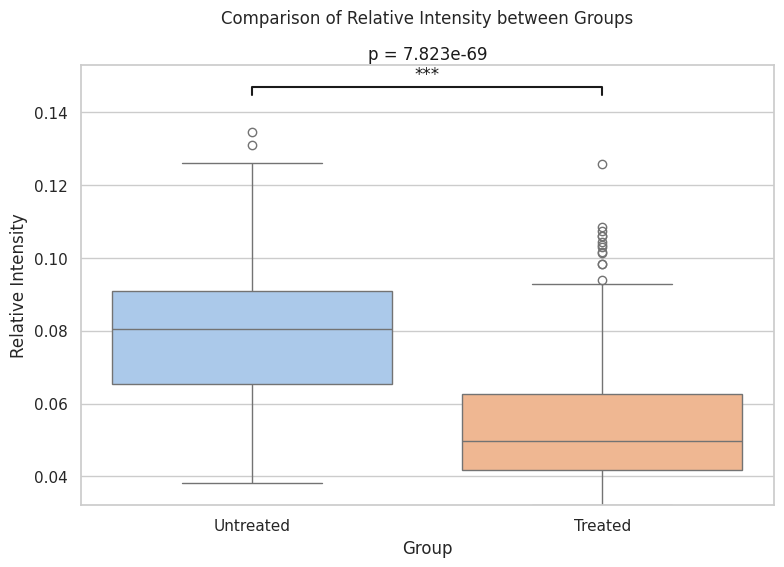

<ipython-input-21-846d113aea1a>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette="pastel", ax=ax)
<ipython-input-21-846d113aea1a>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette="pastel", ax=ax)
<ipython-input-21-846d113aea1a>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=feature, data=df, palette="pastel", ax=ax)


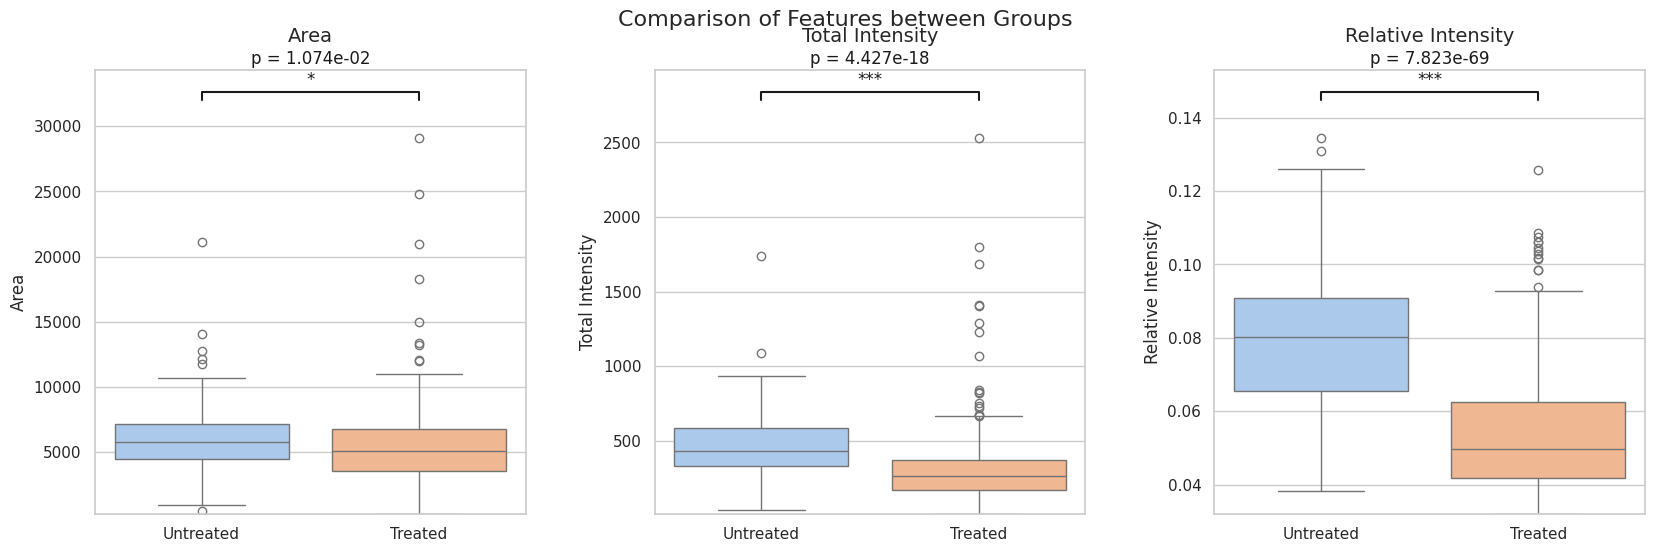

In [21]:
def plot_features_with_pvalues(df, p_values):
    sns.set(style="whitegrid")
    features_to_plot = ['Area', 'Total Intensity', 'Relative Intensity']

    # First, create individual plots
    for feature in features_to_plot:
        plt.figure(figsize=(8, 6))
        ax = sns.boxplot(x='Group', y=feature, data=df, palette="pastel")

        # Increase the pad to move the title higher
        ax.set_title(f'Comparison of {feature} between Groups', pad=30)  # Increased pad value

        # Get the p-value for the current feature
        p_val = p_values.get(feature)

        # Add p-value annotation
        if p_val is not None:
            # Determine significance level
            if p_val < 0.001:
                significance = '***'
            elif p_val < 0.01:
                significance = '**'
            elif p_val < 0.05:
                significance = '*'
            else:
                significance = 'ns'  # Not significant

            # Get positions for annotations
            x1, x2 = 0, 1  # Positions of the two groups on the x-axis
            y_max = df[feature].max()
            y_min = df[feature].min()
            y_range = y_max - y_min
            y, h = y_max + 0.1 * y_range, 0.02 * y_range  # Adjust y position and height

            # Plot the lines for the annotation
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')

            # Add the text annotation
            ax.text((x1 + x2) * 0.5, y + h * 1.5, f'p = {p_val:.3e}\n{significance}',
                    ha='center', va='bottom', color='k')

            # Adjust the y-axis limit to make space for the annotation
            ax.set_ylim(y_min, y + h * 4)

        plt.tight_layout()
        # Adjust the top margin to make space for the title
        plt.subplots_adjust(top=0.85)  # Adjusted top margin

        # Save the plot to a file
        plt.savefig(f"{feature}_comparison_with_pvalues.png")
        plt.show()

    # Now, create a combined plot with all three boxplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    for idx, feature in enumerate(features_to_plot):
        ax = axes[idx]
        sns.boxplot(x='Group', y=feature, data=df, palette="pastel", ax=ax)
        # Increase pad to move titles higher
        ax.set_title(f'{feature}', fontsize=14, pad=20)

        # Get the p-value for the current feature
        p_val = p_values.get(feature)

        # Add p-value annotation
        if p_val is not None:
            # Determine significance level
            if p_val < 0.001:
                significance = '***'
            elif p_val < 0.01:
                significance = '**'
            elif p_val < 0.05:
                significance = '*'
            else:
                significance = 'ns'

            # Get positions for annotations
            x1, x2 = 0, 1
            y_max = df[feature].max()
            y_min = df[feature].min()
            y_range = y_max - y_min
            y, h = y_max + 0.1 * y_range, 0.02 * y_range

            # Plot the annotation lines
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')

            # Add the annotation text
            ax.text((x1 + x2) * 0.5, y + h * 1.5, f'p = {p_val:.3e}\n{significance}',
                    ha='center', va='bottom', color='k')

            # Adjust the y-axis limit
            ax.set_ylim(y_min, y + h * 4)

        # Adjust labels
        ax.set_xlabel('')
        ax.set_ylabel(feature)

    # Adjust layout to prevent overlapping
    plt.subplots_adjust(top=0.85, wspace=0.3)
    fig.suptitle('Comparison of Features between Groups', fontsize=16, y=0.95)

    # Save the combined plot
    plt.savefig("Combined_Features_comparison_with_pvalues.png")
    plt.show()

# Step 3: Call the updated plotting function
plot_features_with_pvalues(features_df, p_values)

In [22]:
def identify_outliers(df, features):
    outlier_indices = []
    for feature in features:
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        feature_outliers = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step )].index
        outlier_indices.extend(feature_outliers)
    outlier_indices = list(set(outlier_indices))
    return df.loc[outlier_indices]

outliers_df = identify_outliers(features_df, ['Area', 'Total Intensity'])
print("Detected outliers:")
print(outliers_df)


Detected outliers:
        Area  Total Intensity  Relative Intensity      Group
262   7826.0       924.994354            0.118195  Untreated
7    12721.0      1089.686487            0.085660  Untreated
264   8579.0       933.330671            0.108792  Untreated
653  10318.0      1068.703001            0.103577    Treated
272  14055.0       803.811911            0.057190  Untreated
656  14964.0      1288.556501            0.086110    Treated
415  13388.0      1683.611902            0.125755    Treated
290   8202.0       911.477620            0.111129  Untreated
679  29128.0      2532.204651            0.086934    Treated
300  21145.0      1738.776391            0.082231  Untreated
686  24773.0      1227.135152            0.049535    Treated
48   12117.0       892.856538            0.073686  Untreated
581  12030.0       646.377025            0.053730    Treated
335   8385.0       898.847724            0.107197  Untreated
594  13208.0      1401.895710            0.106140    Treated
472  

In [23]:
!git --version


git version 2.34.1


In [25]:
!git config --global user.name "AdamkhanBM"
!git config --global user.email "alu0101224077@ull.edu.es"